# **Anderson Localization Simulation and Analysis**

This notebook simulates Anderson Localization of quantum particles using quantum circuits to study the phenomenon in disordered systems. It visualizes how the average position and variance of an excitation evolve over time and as a function of randomness, demonstrating the onset of localization. The notebook includes code for generating Hamiltonians, running quantum simulations, and plotting results for different numbers of qubits and randomness.

In particular, we consider a system of $N$ qubits represented by the state $|\psi\rangle$. We then use the following hamiltonian to describe how the system evolves:
\begin{equation*}
    H = \sum_{i=1}^{N-1} (X_iX_{i+1} + Y_iY_{i+1}) +\sum_i^Nb_iZ_i
\end{equation*}
To see exactly what this hamiltonian describes, we can break it down into two parts:
1. The first summation swaps the values of neighboring qubits, meaning it models interactions between neighboring qubits. If we start with one excited state and apply these "swaps" a few times, it's easy to see how this interaction can be thought of as a "kinetic energy" of an excitation. 
\begin{align*}
    &|1000000000\rangle \\
    &|0100000000\rangle \\
    &|0010000000\rangle \\
    &|0001000000\rangle \\
    &|0000100000\rangle \\
    &|0000010000\rangle \\
    &|0000001000\rangle \\
    &|0000000100\rangle \\
    &|0000000010\rangle \\
    &|0000000001\rangle \\
\end{align*}
Here, we observe how the excitation seems to "move" along the axis, thus representing some sort of "kinetic energy."
2. The second summation represents an external magnetic or other field applied to the system, which creates a sort of potential across the qubits. Thus, we can call this term the "potential energy" term.

If we use a classical analogy, this simulation simulates a rolling on some kind of landscape, where the first term of the Hamiltonian describes the movement of the ball and the second term describes the shape of the landscape. In the quantum world, however, the ball behaves a lot less like a ball and more like a wave. 

Finally, Anderson Localization is the phoenomenon relating the randomness of the potential energy term (i.e. changing the randomness of the $b_i$ values) to the localization of the excitation. As we raise randomness, the excitation scatters more and more, randomizing individual phases causing desctructive interference outisde of a small area where the excittion is localized.

In [4]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
import scipy
import functools as ft
import random
from scipy.signal import savgol_filter as savitzky_golay

X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])
I = np.identity(2)

In [ ]:
qubits = 9 # Number of qubits in the system
total_time = 20 # Total time for the simulation
time_step = 0.2 # Time step size
shots = 1000 # Number of shots for the simulation
randomness = 15 # Randomness factor for the Hamiltonian

In [42]:
# Function to make hamiltonian constructing a bit easier
def get_gi(gate, i, n, get_gi1=False):
    gates = []
    for j in range(n):
        if j == i or (j == i+1 and get_gi1):
            gates.append(gate)
        else:
            gates.append(I)
    return ft.reduce(np.kron, gates)

# Creates a Hamiltonian for the Anderson model
def construct_hamiltonian(rnd, n):
    b = [random.random()*rnd for i in range(n)]
    b2 = [1 for i in range(n-1)]

    h1 = sum(b2[i]*(get_gi(X, i, n, True) + get_gi(Y, i, n, True)) for i in range(n-1))
    h2 = sum((b[i] * get_gi(Z, i, n)) for i in range(n))
    return h1 + h2

h = construct_hamiltonian(randomness, qubits)
# Converts Hamiltonian into time evolution operator
def u(t, H=h):
    return scipy.linalg.expm(-1j * H * t)

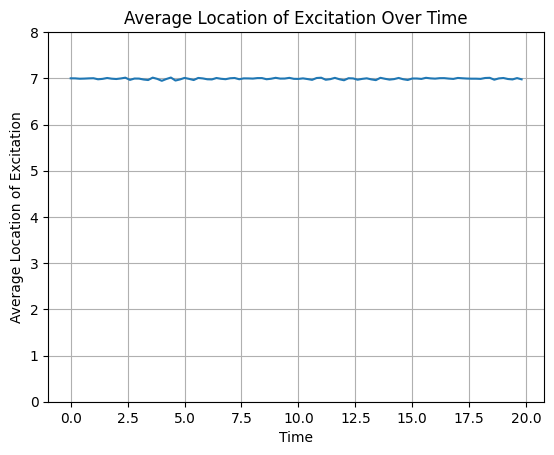

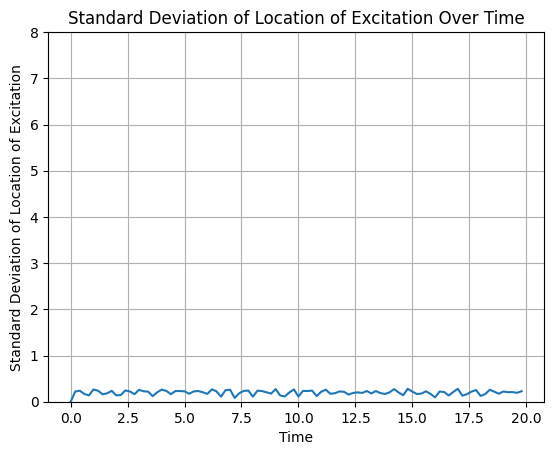

In [45]:
# Plots the variance and location of the 1 qubit as time progresses
# Low variance indicates that the 1 qubit is being localized
simulator = Aer.get_backend('aer_simulator')
r = np.arange(0, total_time, time_step)
avg_locations = []
stdevs = []

frequencies = []
      
for t in r:
    qc = QuantumCircuit(qubits)
    qc.x(7) # create state with one qubit in the |1> state (represents the excitation)
    qc.unitary(u(t), range(qubits))
    qc.measure_all()

    compiled_circuit = transpile(qc, simulator)
    job = simulator.run(compiled_circuit, shots=shots)
    result = job.result()
    counts = dict(result.get_counts())

    avg_location = 0
    for bitstring, freq in sorted(counts.items(), key=lambda x: x[1], reverse=True):
        location = qubits-1-bitstring.index('1')
        avg_location += location * freq / shots
        #print(f"{bitstring.replace("0", "-")}: {freq}", end='; ')
    #print(avg_location)

    variance = 0
    for bitstring, freq in sorted(counts.items(), key=lambda x: x[1], reverse=True):
        location = qubits-1-bitstring.index('1')
        variance += (location - avg_location) ** 2 * freq / shots
        frequencies.append([t, location - 0.5, freq / shots]) # subtract 0.5 to center tick marks when graphing

    avg_locations.append(avg_location)
    stdevs.append(variance ** .5)

plt.plot(r, avg_locations)
plt.xlabel('Time')
plt.ylabel('Average Location of Excitation')
plt.ylim(0, qubits-1)
plt.title('Average Location of Excitation Over Time')
plt.grid()
plt.show()

plt.plot(r, stdevs)
plt.xlabel('Time')
plt.ylabel('Standard Deviation of Location of Excitation')
plt.ylim(0, qubits-1)
plt.title('Standard Deviation of Location of Excitation Over Time')
plt.grid()
plt.show()

*Notes*

The above code generates two graphs: the first is the mean location of the excitation and the second is the standard deviation of the excitation. In the simple case of a flat potential, the excitation simply bounces back and forth. After some time, though, the bouncing decays due to the wavelike nature of the excitation causing the particle to spread out more.

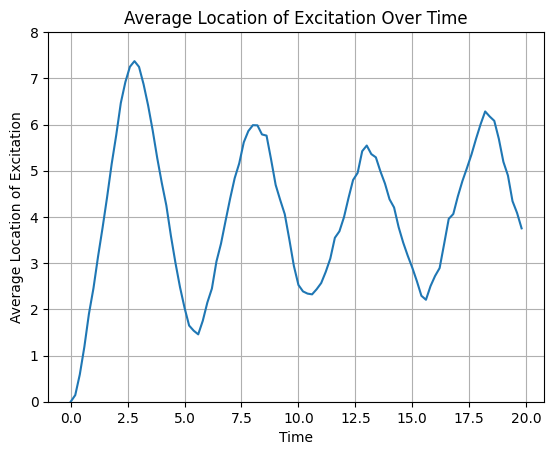 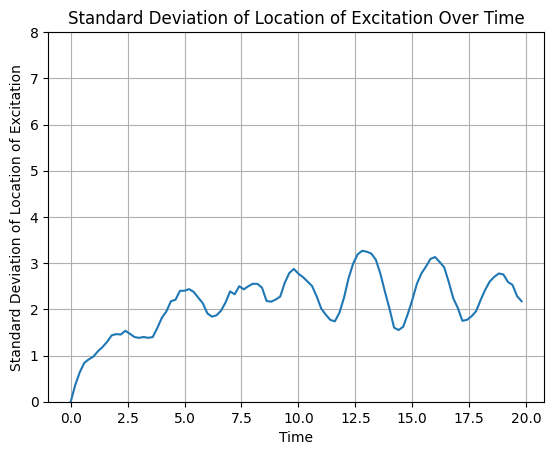

If we increase the randomness sufficiently high, the excitation's position stops bouncing and the excitation is said to be localized.
Randomness factor: 15

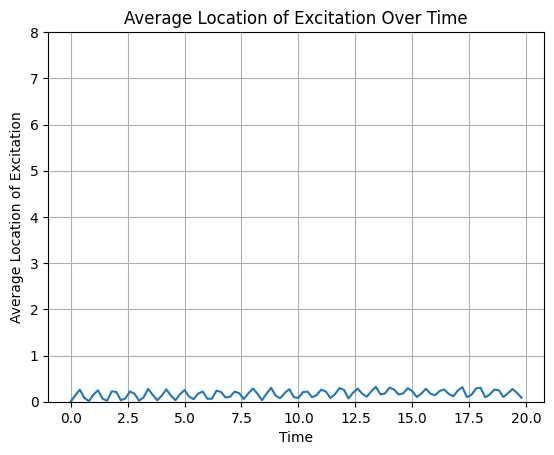 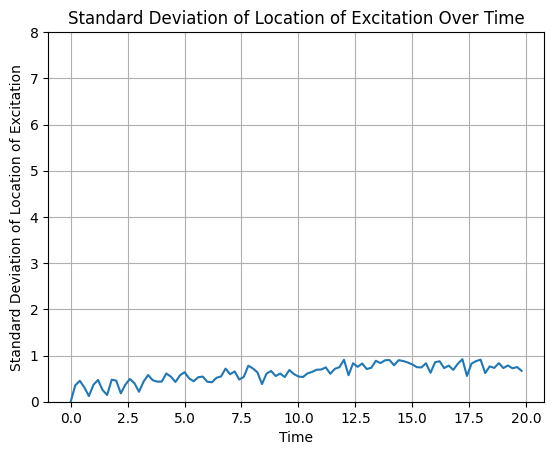

However, a localized position does not always mean a localized particle. For example, the following excitation seems to be localized:

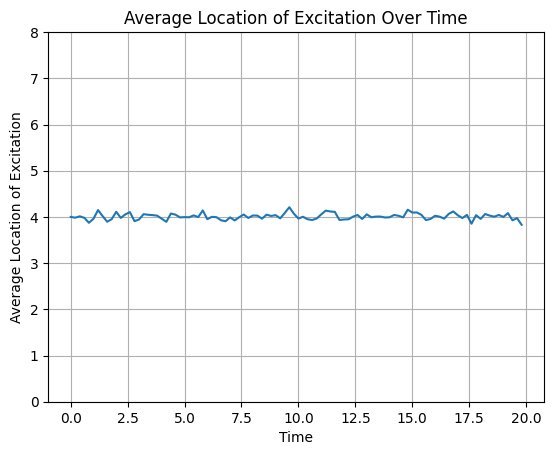

If we look at the standard deviation graph, though, it obviously isn't localized.

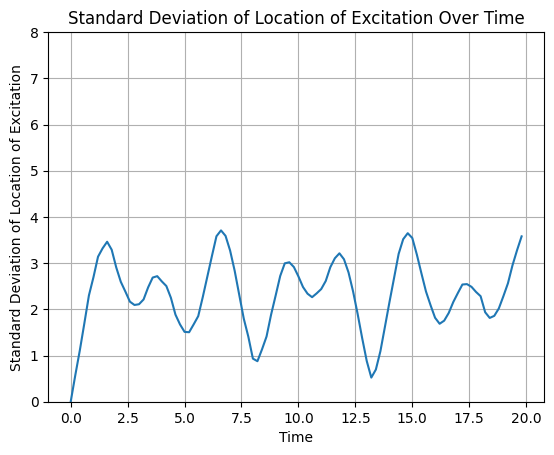

Why is there a discrepancy? In this case the excitation was placed directly in the middle of the qubit row, causing the excitation to "spread out" evenly in all directions creating a mean position that doesn't seem to move. Thus, standard deviation is an importnat quantity to look at when determining localization

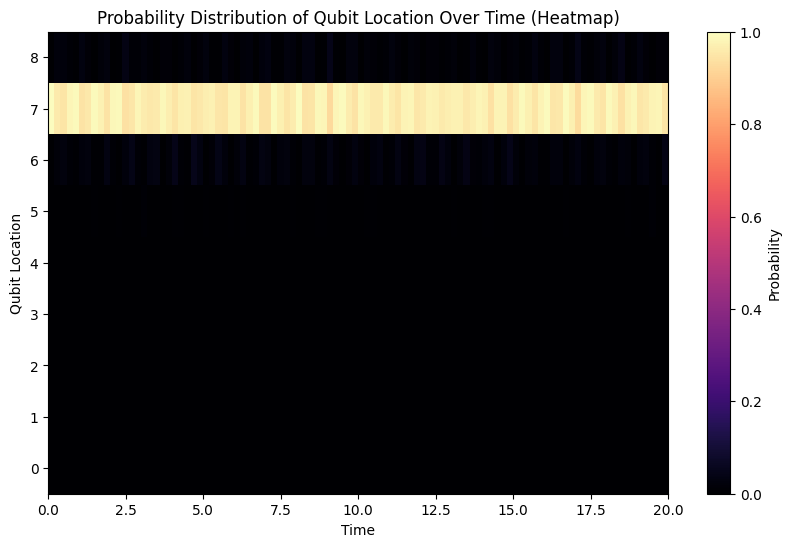

In [46]:
# Convert frequencies to numpy array for easier manipulation
freq_arr = np.array(frequencies)
locations = np.arange(-0.5, qubits-0.5, 1)
probs = freq_arr[:, 2]

# Create a 2D grid for the heatmap

heatmap = np.zeros((len(locations), len(r)))

for t, loc, p in freq_arr:
    time_idx = np.where(r == t)[0][0]
    loc_idx = np.where(locations == loc)[0][0]
    heatmap[loc_idx, time_idx] = p

plt.figure(figsize=(10, 6))
im = plt.imshow(
    heatmap,
    aspect='auto',
    origin='lower',
    cmap='magma',
    extent=[0, total_time, -.5, qubits-.5]
)
plt.colorbar(im, label='Probability')
plt.xlabel('Time')
plt.ylabel('Qubit Location')
plt.title('Probability Distribution of Qubit Location Over Time (Heatmap)')
plt.ylim(-0.5, qubits-0.5)
# show every tick on y axis
plt.yticks(np.arange(0, qubits, 1), np.arange(0, qubits, 1))

plt.grid(False)
plt.show()

*Notes*

Heat maps are an easy way to visualize the movement of quantum particles! In this case, the hotter the color is, the more likely you are to find the particle there. Here are a few graphs we generated using this technique:

1. Starting Position: 0, Randomness: 0 (normal bouncing motion)

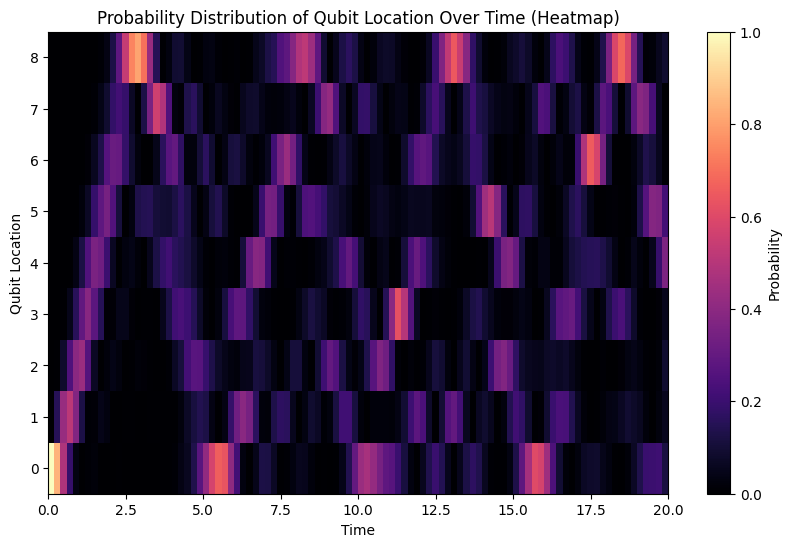

2. Starting position: 4 (middle), Randomness: 0 (not localized but average position is in the middle)

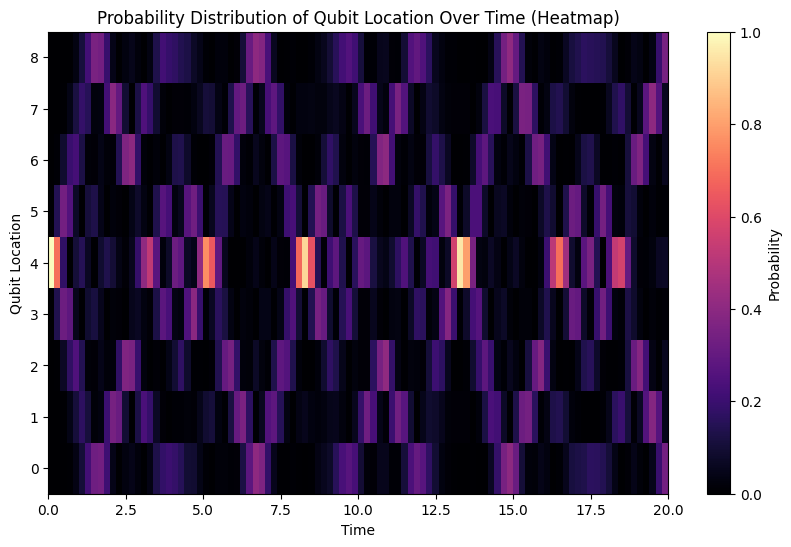

3. Starting position: 3, Randomness: 7 (partially localized)

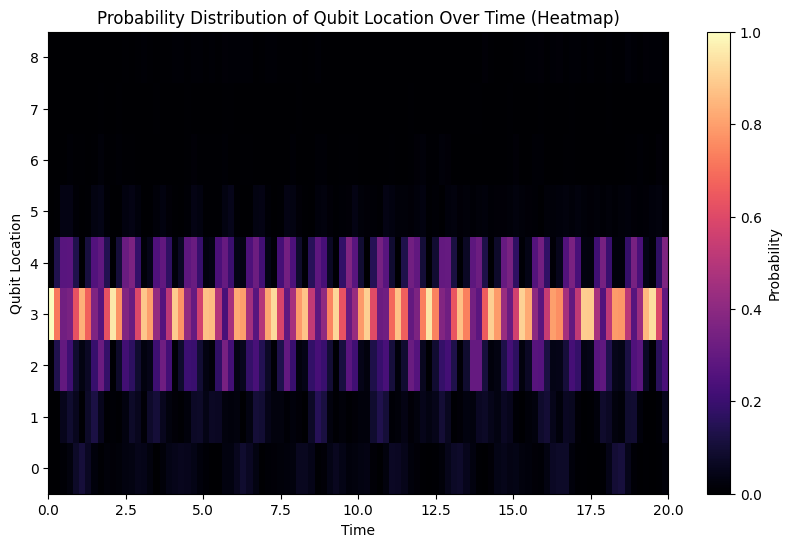

4. Starting position: 7, Randomness: 15 (fully localized)

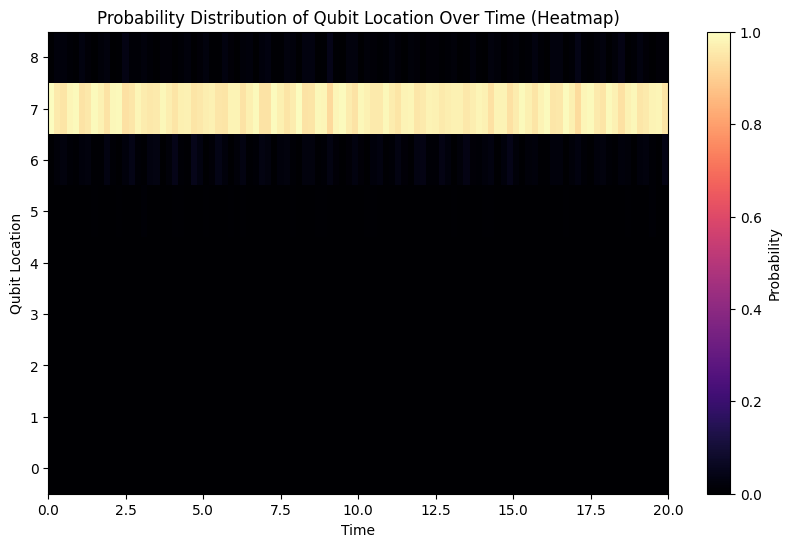

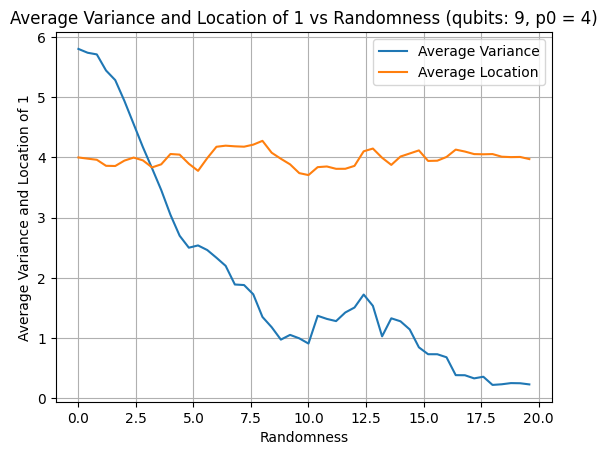

In [47]:
qbits = 9

# Returns the average variance and location of 1 for different randomness values
def anderson_random_data(hamiltonian, qubits=qbits):
    r = np.arange(0, 10, .5)
    shots = 1000
    avg_locations = []
    variances = []

    for t in r:
        qc = QuantumCircuit(qubits)
        qc.x(qbits//2) # create state with 1 qubit in the |1> state

        qc.unitary(scipy.linalg.expm(-1j * hamiltonian * t), range(qubits))
        qc.measure_all()

        compiled_circuit = transpile(qc, simulator)
        job = simulator.run(compiled_circuit, shots=shots)
        result = job.result()
        counts = dict(result.get_counts())

        avg_location = 0
        for bitstring, freq in sorted(counts.items(), key=lambda x: x[1], reverse=True):
            location = qubits-1-bitstring.index('1')
            avg_location += location * freq / shots
            #print(f"{bitstring.replace("0", "-")}: {freq}", end='; ')
        #print(avg_location)

        variance = 0
        for bitstring, freq in sorted(counts.items(), key=lambda x: x[1], reverse=True):
            location = qubits-1-bitstring.index('1')
            variance += (location - avg_location) ** 2 * freq / shots

        avg_locations.append(avg_location)
        variances.append(variance)

    return np.average(variances), np.average(avg_locations)

# Array to store the average variance and location of 1 for different randomness values

quantities_by_randomness = []
L=20
for i in np.arange(0, L, 0.4):
    H_i = construct_hamiltonian(i, n=qbits)
    quantities_by_randomness.append(anderson_random_data(H_i, qubits=qbits))

# Simple running average smoothening function to smooth the variance data, making it easer to visualize trends
def smooth(y, r):
    smooth = []
    for i in range(len(y)):
        if i < r:
            smooth.append(np.mean(y[:i+1]))
        elif i >= len(y) - r:
            smooth.append(np.mean(y[i-r:]))
        else:
            smooth.append(np.mean(y[i-r:i+r+1]))
    return np.array(smooth)

stdevs = [q[0] for q in quantities_by_randomness]
positions = [q[1] for q in quantities_by_randomness]
plt.plot(np.arange(0, L, 0.4), smooth(stdevs, 3))
plt.plot(np.arange(0, L, 0.4), smooth(positions, 3))
plt.xlabel('Randomness')
plt.ylabel('Average Variance and Location of 1')
plt.title(f'Average Variance and Location of 1 vs Randomness (qubits: {qbits}, p0 = 4)')
plt.legend(['Average Variance', 'Average Location'])
plt.grid()
plt.show()

**Some Notes**

For systems where the 1 qubit starts from position 0, the 1 qubit very clearly becomes localized as the randomness factor ($r$ where $b = $ math.random()*$r$) increases. The graphs pretty clearly indicate this trend, as both the time-averaged position and variance decrease rapidly as the randomness increases. For 7 qubits, this factor is around 10.

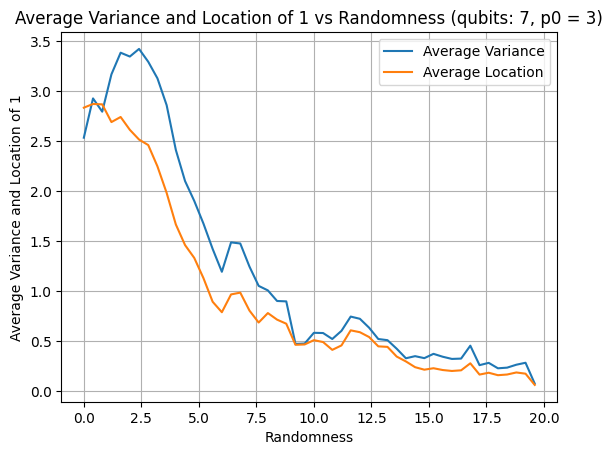

Checking for other numbers of qubits:

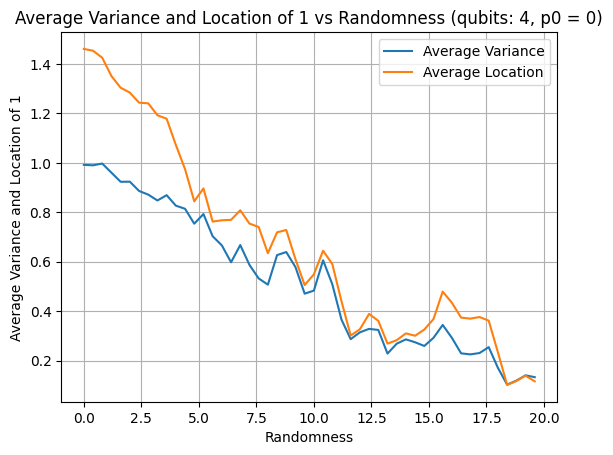 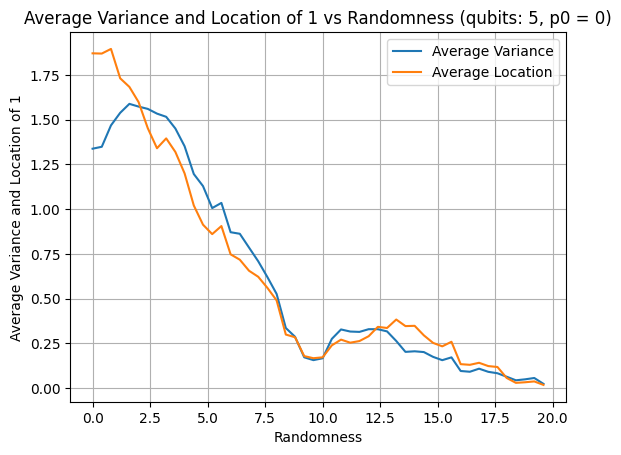 
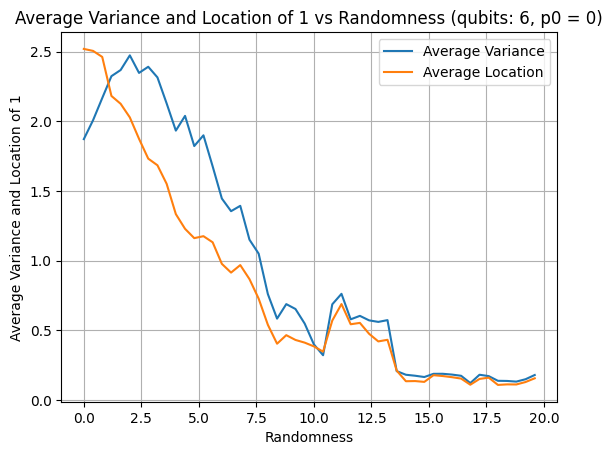 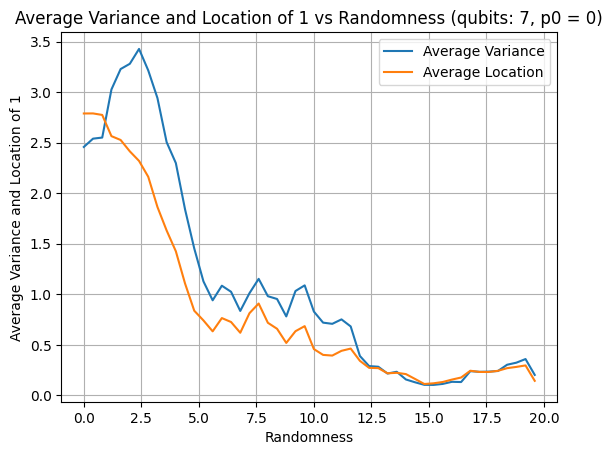
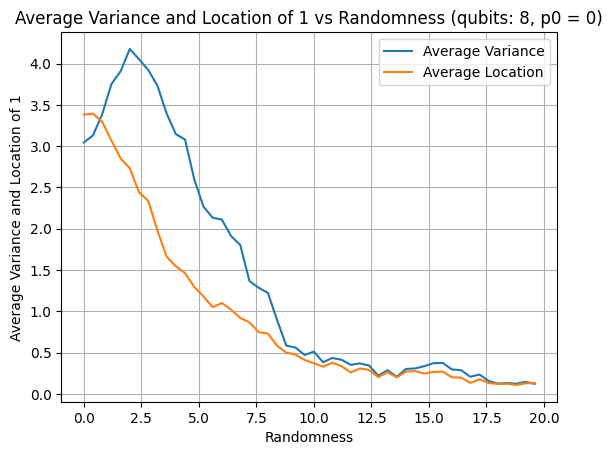 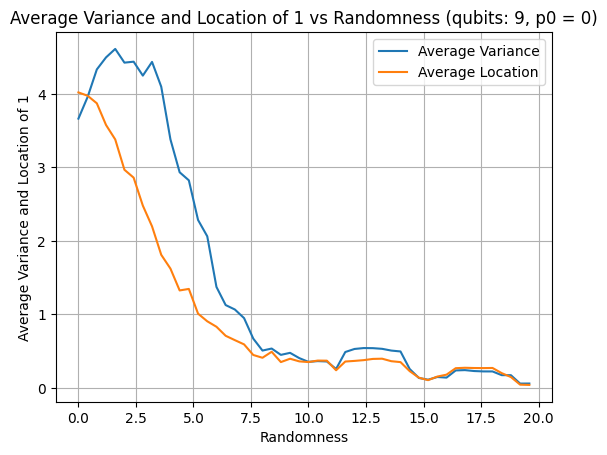

Localization consistiently occurs around a randomness factor of 10, which shows that localization is independent of the "length" of the axis. Going across the $x$ axis of the graphs, we see that the variance actually increases slightly before decreasing. This slight increase likely happens since as we increase the randomness, the particle gets "josteled around" by the random terrain that increases variance a bit before localization effects fully take over.

For systems where the 1 qubit starts at the middle of the system, the average location is in the middle regardless of the randomness factor because of symmetry. However, looking at the variance graph clearly shows that the particle still becomes localized for sufficiently large randomness factors.

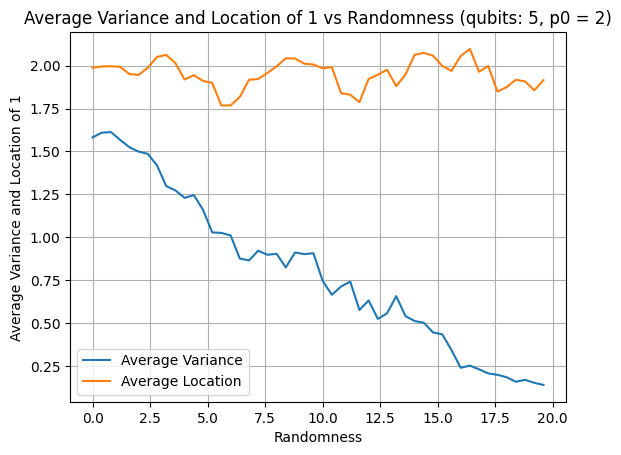 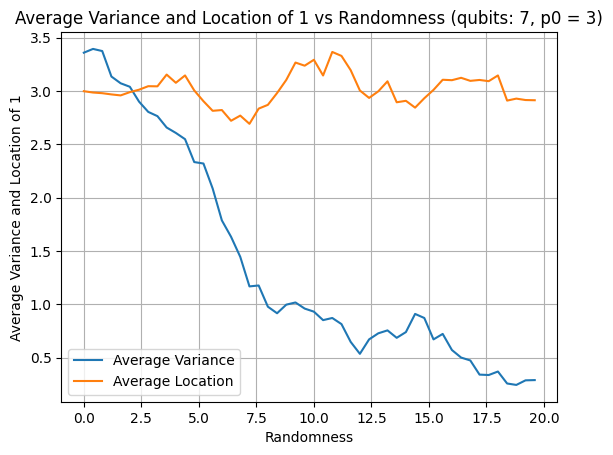
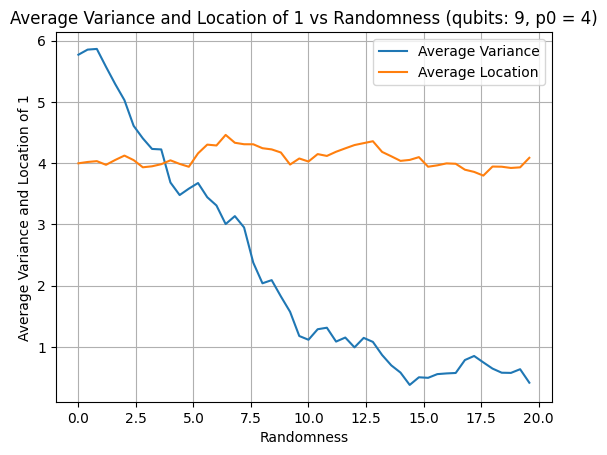

For these, the variance follows a similar trend as the ones depicted earlier.